<a href="https://colab.research.google.com/github/linainsaf/ML-M1/blob/main/RESNET_PNEUMONIA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [80]:
#import librairies 
import glob 
import random
import os
import seaborn as sns
import time
import numpy as np

np.random.seed(123) # for reproducibility

from PIL import Image

import torch 
import torchvision
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import Conv2DTranspose, Reshape, Dense, Activation, Flatten, Dropout, Convolution2D, MaxPooling2D, Input
from keras.preprocessing.image import ImageDataGenerator


from tqdm.auto import tqdm
from matplotlib import pyplot as plt
import cv2
from skimage.transform import resize

In [2]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

##  Data preparation :

In [3]:
#prepare data 
train = get_training_data('drive/MyDrive/chest_xray/chest_xray/train')
test = get_training_data('drive/MyDrive/chest_xray/chest_xray/test')


OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


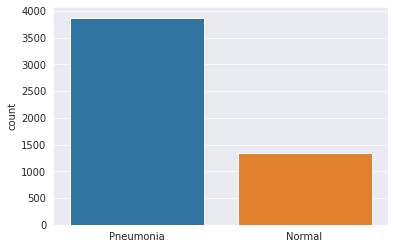

In [4]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l) 

Text(0.5, 1.0, 'NORMAL')

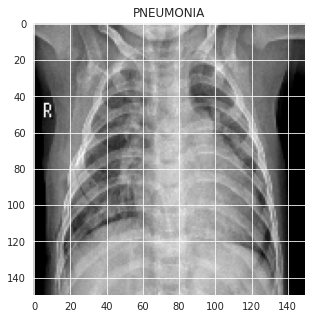

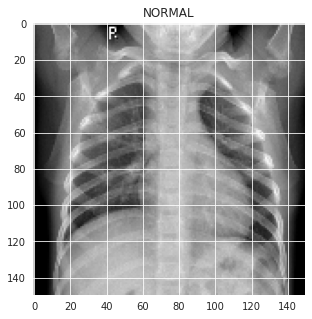

In [5]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [28]:
x_train = []
y_train = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

## Reshaping X data :

Now let’s get back to our X_train and X_test. It’s important to know that the shape of these two arrays are (5216, 150, 150) and (624, 150, 150) respectively. Well, at glance, these two shapes look fine as we can just display that using plt.imshow() function. However,  this shape is just not acceptable by the convolution layer since it expects a color channel to be included as its input.

Thus, since this image is essentially colored in grayscale, then we need to add a new axis with 1 dimension which is going to be recognized by the convolution layer as the only color channel. 

In [29]:
# resize data for deep learning 
x_train = np.reshape(x_train,(-1, img_size, img_size, 1))
y_train = np.array(y_train)

x_test = np.reshape(x_test,(-1, img_size, img_size, 1))
y_test = np.array(y_test)
# Normalize the data /255
X_train = np.array(x_train) 
X_test = np.array(x_test) 
# Preprocess class labels
Y_train = tf.keras.utils.to_categorical(y_train, 2)
Y_test = tf.keras.utils.to_categorical(y_test, 2)

## Saving Data

In [30]:
np.savez_compressed('X_train',X_train)
np.savez_compressed('X_test',X_test)
np.savez_compressed('Y_train',Y_train)
np.savez_compressed('Y_test',Y_test)

In [31]:
X_train, Y_train, X_test, Y_test = np.load('X_train.npz',allow_pickle=True),np.load('Y_train.npz'),np.load('X_test.npz'),np.load('Y_test.npz')

In [32]:
X_train=X_train['arr_0']
X_test=X_test['arr_0']
Y_train=Y_train['arr_0']
Y_test=Y_test['arr_0']

In [34]:
print("Dimensions de X_train : ", np.shape(X_train))
print("Dimensions de X_test : ", np.shape(X_test))
print("Dimensions de y_train : ", np.shape(Y_train))
print("Dimensions de y_test : ", np.shape(Y_test))

Dimensions de X_train :  (5216, 150, 150, 1)
Dimensions de X_test :  (624, 150, 150, 1)
Dimensions de y_train :  (5216, 2)
Dimensions de y_test :  (624, 2)


In [35]:
print("nombre d'images en train : ", len(X_train))
print("nombre d'images en test : ", len(X_test))

print("la taille des images est : ", len(X_train[0]),'x',len(X_train[0][0]),"pixels")

print("Nombre de  de classes : ", Y_test.shape[1])

nombre d'images en train :  5216
nombre d'images en test :  624
la taille des images est :  150 x 150 pixels
Nombre de  de classes :  2


## Data augmentation :
The main point of augmenting data — or more specifically augmenting train data is that we are going to increase the number of data used for training by creating more samples with some sort of randomness on each of them. These randomnesses might include translations, rotations, scaling, shearing, and flips.

Such a technique is able to help our neural network classifier to reduce overfitting, or in other words, it can make the model generalize data samples better. Luckily, the implementation is very easy thanks to the existence of ImageDataGenerator object which can be imported from the Keras module.



In [18]:
datagen = ImageDataGenerator(
        rotation_range = 10,  
        zoom_range = 0.1, 
        width_shift_range = 0.1, 
        height_shift_range = 0.1)

In [19]:
datagen.fit(X_train)
train_gen = datagen.flow(X_train, y_train_one_hot, batch_size=32)

NameError: ignored

## CNN (Convolutional Neural Network): 
Now it’s time to actually build the neural network architecture. Let’s start with the input layer (input1). So this layer basically takes all the image samples in our X data. Hence we need to ensure that the first layer accepts the exact same shape as the image size. It’s worth noting that what we need to define is only (width, height, channels), instead of (samples, width, height, channels).

Afterward, this input1 layer is connected to several convolution-pooling layer pairs before eventually being flattened and connected to dense layers. Notice that all hidden layers in the model are using the ReLU activation function due to the fact that ReLU is faster to compute compared to sigmoid, and thus, the training time required is shorter. Lastly, the last layer to connect is output1, which consists of 3 neurons with a softmax activation function.

Here softmax is used because we want the outputs to be the probability value of each class

### Model 1:

In [44]:
inputs = Input(shape=(150,150,1)) 
x = inputs
x = Convolution2D(32, kernel_size = (3, 3), activation='relu' )(x) 
x = Convolution2D(64, kernel_size = (3, 3), activation='relu' )(x) 
x = MaxPooling2D((3, 3))(x) 
x = Flatten()(x) 
x = Dense(256, activation='relu')(x) 
x = Dropout(0.5)(x) 
outputs= Dense(2, activation='softmax')(x) 
model = Model(inputs, outputs) 
model.summary() 

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 150, 150, 1)]     0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 148, 148, 32)      320       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 146, 146, 64)      18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 147456)            0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               37748992  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0   

In [45]:
def affiche(history):
 # summarize history for accuracy
 plt.plot(history.history['accuracy'])
 plt.plot(history.history['val_accuracy'])
 plt.title('model accuracy')
 plt.ylabel('accuracy')
 plt.xlabel('epoch')
 plt.legend(['train', 'test'], loc='upper left')
 plt.show()
 # summarize history for loss
 plt.plot(history.history['loss'])
 plt.plot(history.history['val_loss'])
 plt.title('model loss')
 plt.ylabel('loss')
 plt.xlabel('epoch')
 plt.legend(['train', 'test'], loc='upper left')
 plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


Epoch 1/5
21/21 [==============================] - 6s 288ms/step - loss: 71.6101 - accuracy: 0.5981 - val_loss: 0.7165 - val_accuracy: 0.6250
Epoch 2/5
21/21 [==============================] - 6s 283ms/step - loss: 0.5286 - accuracy: 0.7476 - val_loss: 0.5718 - val_accuracy: 0.6298
Epoch 3/5
21/21 [==============================] - 6s 286ms/step - loss: 0.4331 - accuracy: 0.7898 - val_loss: 0.4915 - val_accuracy: 0.7083
Epoch 4/5
21/21 [==============================] - 6s 290ms/step - loss: 0.3334 - accuracy: 0.8636 - val_loss: 0.4818 - val_accuracy: 0.7500
Epoch 5/5
21/21 [==============================] - 6s 293ms/step - loss: 0.2805 - accuracy: 0.8960 - val_loss: 0.5105 - val_accuracy: 0.7628


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


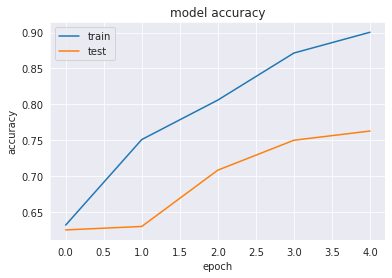

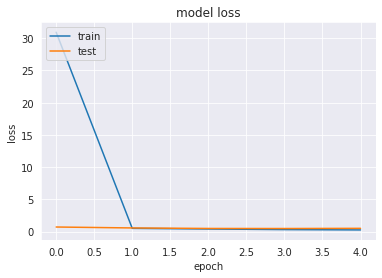

lr= 0.0001 batch_size= 256 epochs= 5
Temps d apprentissage 22.362273000000016


In [46]:
lr= 0.0001
batch_size=256
epochs=5
sgd1= tf.keras.optimizers.SGD(learning_rate=lr,momentum=0.9)
model.compile(loss='categorical_crossentropy', optimizer=sgd1, metrics=['accuracy'])
tps1 = time.clock()
history =model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs,verbose=1,validation_data=(X_test, Y_test))
tps2 = time.clock()
affiche(history) #donnee en annexe
print('lr=',lr,'batch_size=',batch_size, 'epochs=',epochs)
print('Temps d apprentissage',tps2 - tps1)

### Model 2:

In [42]:
input1 = Input(shape=(X_train.shape[1], X_train.shape[2], 1))

cnn = Convolution2D(16, (3, 3), activation='relu', strides=(1, 1), 
    padding='same')(input1)
cnn = Convolution2D(32, (3, 3), activation='relu', strides=(1, 1), 
    padding='same')(cnn)
cnn = MaxPooling2D((2, 2))(cnn)

cnn = Convolution2D(16, (2, 2), activation='relu', strides=(1, 1), 
    padding='same')(cnn)
cnn = Convolution2D(32, (2, 2), activation='relu', strides=(1, 1), 
    padding='same')(cnn)
cnn = MaxPooling2D((2, 2))(cnn)

cnn = Flatten()(cnn)
cnn = Dense(100, activation='relu')(cnn)
cnn = Dense(50, activation='relu')(cnn)
output1 = Dense(2, activation='softmax')(cnn)

model = Model(inputs=input1, outputs=output1)
model.summary() 


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 150, 150, 1)]     0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 150, 150, 16)      160       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 150, 150, 32)      4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 75, 75, 16)        2064      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 75, 75, 32)        2080      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 37, 37, 32)        0   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


Epoch 1/5
21/21 [==============================] - 5s 229ms/step - loss: 2.6747 - accuracy: 0.5971 - val_loss: 0.6530 - val_accuracy: 0.6154
Epoch 2/5
21/21 [==============================] - 5s 225ms/step - loss: 0.5326 - accuracy: 0.7604 - val_loss: 0.6118 - val_accuracy: 0.6571
Epoch 3/5
21/21 [==============================] - 5s 228ms/step - loss: 0.3587 - accuracy: 0.8436 - val_loss: 0.4758 - val_accuracy: 0.7516
Epoch 4/5
21/21 [==============================] - 5s 230ms/step - loss: 0.2546 - accuracy: 0.8986 - val_loss: 0.4458 - val_accuracy: 0.7821
Epoch 5/5
21/21 [==============================] - 5s 230ms/step - loss: 0.1876 - accuracy: 0.9301 - val_loss: 0.4620 - val_accuracy: 0.7949


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


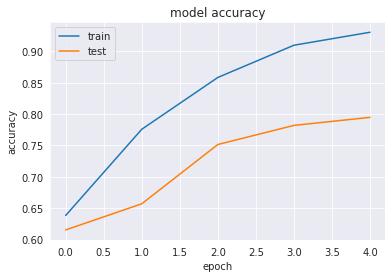

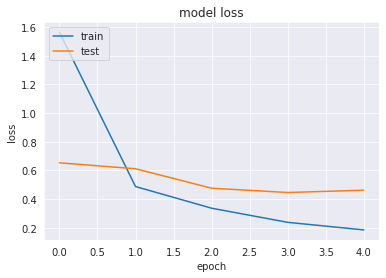

lr= 0.0001 batch_size= 256 epochs= 5
Temps d apprentissage 18.520363000000003


In [43]:
lr= 0.0001
batch_size=256
epochs=5
sgd2= tf.keras.optimizers.SGD(learning_rate=lr,momentum=0.9)
model.compile(loss='categorical_crossentropy', optimizer=sgd2, metrics=['accuracy'])
tps1 = time.clock()
history =model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs,verbose=1,validation_data=(X_test, Y_test))
tps2 = time.clock()
affiche(history) #donnee en annexe
print('lr=',lr,'batch_size=',batch_size, 'epochs=',epochs)
print('Temps d apprentissage',tps2 - tps1)

### Model evaluation


In [90]:
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
Y_truth=np.argmax(Y_test, axis=1)

In [91]:
cm = confusion_matrix(Y_truth, predicted_classes)

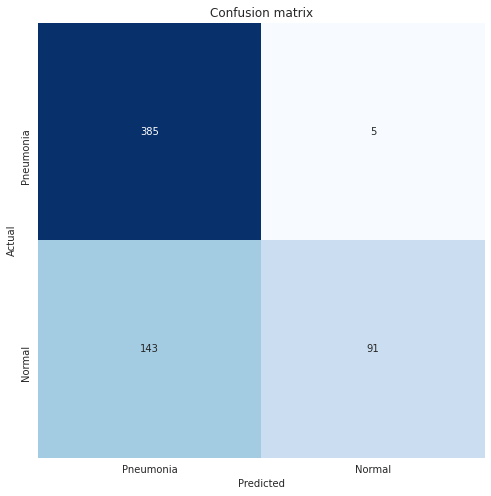

In [92]:
classnames = ['Pneumonia', 'Normal']
plt.figure(figsize=(8,8))
plt.title('Confusion matrix')
sns.heatmap(cm, cbar=False, xticklabels=classnames, yticklabels=classnames, fmt='d', annot=True, cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()